### 绘制Maxwell模型线性及不同时间步的相关图

In [25]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'svg'
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")
    


系统已安装 Arial 字体


In [27]:
current_directory = os.getcwd()
print(current_directory)
# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("No GPU available, using CPU instead.")

/share/users/fxy/work/Constitutive_Equation/stress_strain_fitting
Using GPU: NVIDIA GeForce RTX 3090


In [28]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
# 读取数据
url = 'data/simple_maxwell_data.xlsx'

df = pd.read_excel(url, sheet_name=None)
data_HF = [[k, v] for k, v in df.items()]  # k is the sheet name, v is the pandas df
# 循环遍历 data_HF 列表并获取下标
data_train=pd.DataFrame()
data_valid=pd.DataFrame()
for i, (sheet_name, sheet_data) in enumerate(data_HF):
    # 去除 sheet_data 中的零值
    sheet_data = sheet_data[(sheet_data != 0).all(axis=1)]
    if i==2:
        data_valid=sheet_data
    else:
        data_train=pd.concat([data_train, sheet_data], ignore_index=True)

df_hf = pd.concat([data_train, data_valid], ignore_index=True)


x1_d_HF = torch.tensor(data_train['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_d_HF = torch.tensor(data_train['n'].values, dtype=torch.float32).view(-1, 1)
y1_d_HF = torch.tensor(data_train['Stress'].values, dtype=torch.float32).view(-1, 1)
# 计算边界

x1min, x1max = torch.min(x1_d_HF), torch.max(x1_d_HF)
x2min, x2max = torch.min(x2_d_HF), torch.max(x2_d_HF)
y1min, y1max = torch.min(y1_d_HF), torch.max(y1_d_HF)

lb = torch.tensor([x1min, x2min, y1min], dtype=torch.float32).numpy()
ub = torch.tensor([x1max, x2max,y1max], dtype=torch.float32).numpy()
# 归一化函数
def norm(vectors, lb, ub):
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors

x1_d_HF = norm(x1_d_HF, lb[0], ub[0])
x2_d_HF = norm(x2_d_HF, lb[1], ub[1])
y1_d_HF = norm(y1_d_HF, lb[2], ub[2])
# 合并数据
X_data_HF = torch.cat([x1_d_HF, x2_d_HF], dim=1)
y_data_HF= torch.cat([y1_d_HF], dim=1) # 默认训练储存模量

Xy_data_HF = torch.cat([X_data_HF,y_data_HF], dim=1)

Shuffle = False # 是否打乱训练
if Shuffle:
    Xy_data_HF = Xy_data_HF[torch.randperm(Xy_data_HF.size(0))]
    #Xy_data_LF = Xy_data_LF[torch.randperm(Xy_data_LF.size(0))]
    X_data_HF = Xy_data_HF[:, 0:4]
    y_data_HF = Xy_data_HF[:, 4:5]
    #X_data_LF = Xy_data_LF[:, 0:3]
    #y_data_LF = Xy_data_LF[:, 3:4]

# 定义模型
in_dim, out_dim = 2, 1

x1_d_valid = torch.tensor(data_valid['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_d_valid = torch.tensor(data_valid['n'].values, dtype=torch.float32).view(-1, 1)

y1_d_valid = torch.tensor(data_valid['Stress'].values, dtype=torch.float32).view(-1, 1)

x1_d_valid = norm(x1_d_valid, lb[0], ub[0])
x2_d_valid = norm(x2_d_valid, lb[1], ub[1])
y1_d_valid = norm(y1_d_valid, lb[2], ub[2])

# 合并数据
X_data_valid = torch.cat([x1_d_valid, x2_d_valid], dim=1)
y_data_valid= torch.cat([y1_d_valid], dim=1)

In [29]:
# 定义时间步长
time_steps = 3

# 动态窗口实现
def create_dynamic_window(data, time_steps):
    """
    通过动态窗口将数据调整为适合 LSTM 输入的格式。
    :param data: 输入数据，形状为 (num_samples, ...)
    :param time_steps: 时间步长
    :return: 调整后的数据，形状为 (num_samples - time_steps + 1, time_steps, ...)
    """
    num_samples = data.shape[0]
    if num_samples < time_steps:
        raise ValueError("样本数量必须大于等于时间步长")
    
    # 创建动态窗口
    windowed_data = []
    for i in range(num_samples - time_steps + 1):
        window = data[i:i + time_steps]
        windowed_data.append(window)
    
    return torch.stack(windowed_data)

In [30]:
# 神经网络的类
class DNN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(DNN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

In [31]:
class GRU_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model using GRU."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 hidden_size=20,  # GRU 隐藏层的维度
                 num_layers=4,    # GRU 层数
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 fc_hidden_size=10,  # 新增全连接层的隐藏维度
                 **kwargs):
        super(GRU_NeuralNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.fc_hidden_size = fc_hidden_size  # 新增全连接层的隐藏维度

        # 添加 GRU 层
        self.gru = nn.GRU(input_dim, hidden_size, num_layers, batch_first=True)
        
        # 添加全连接层（新增）
        self.fc = nn.Linear(hidden_size, fc_hidden_size)
        
        # 添加输出层
        self.out = nn.Linear(fc_hidden_size, output_dim)
        
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(param)
            nn.init.xavier_normal_(self.fc.weight)  # 初始化新增的全连接层
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
            nn.init.xavier_uniform_(self.fc.weight)  # 初始化新增的全连接层
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):
        # GRU 输入形状: (batch_size, seq_len, input_dim)
        # GRU 输出形状: (batch_size, seq_len, hidden_size)
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        
        # 通过 GRU 层
        gru_out, _ = self.gru(X, h0)
        
        # 取最后一个时间步的输出
        last_time_step = gru_out[:, -1, :]  # (batch_size, hidden_size)
        
        # 通过新增的全连接层
        fc_out = self.fc(last_time_step)
        if self.activation:
            fc_out = self.activation(fc_out)  # 应用激活函数
        
        # 通过输出层
        Z = self.out(fc_out)
        
        return Z

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'svg'
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")
    


系统已安装 Arial 字体


<ipython-input-33-39db9c65eb06>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_l=torch.load('model/maxwell_dnn_linear_l.pth')
<ipython-input-33-39db9c65eb06>:2: Futu

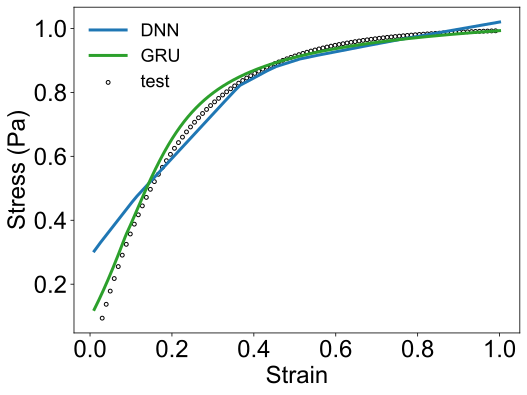

In [33]:
model_l=torch.load('model/maxwell_dnn_linear_l.pth')
model_nl=torch.load('model/maxwell_dnn_linear_nl.pth')
model=torch.load('model/maxwell_gru_linear_full.pth')
model_l.eval()
model.eval()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24
# 颜色字典
colors = {
    'red': 'tab:red',
    'orange': 'tab:orange',
    'yellow': '#f9c74f',
    'green': 'tab:green',
    'cyan': 'tab:cyan',
    'blue': 'tab:blue',
    'purple': 'tab:purple',
    'brown': 'tab:brown',
    'pink': 'tab:pink',
    'black': '#000000'  # 添加黑色
}
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors
N=df_hf['n'].unique()
test_data=data_valid 
# 计算等间隔的索引
num_points = len(test_data)
step = max(1, num_points // 100)  # 确保步长至少为1
sampled_indices = range(0, num_points, step)
        
# 按等间隔取点
sampled_test_data = test_data.iloc[sampled_indices]

x1_test = torch.tensor(test_data['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_test = torch.tensor(test_data['n'].values, dtype=torch.float32).view(-1, 1)
y1_test = torch.tensor(test_data['Stress'].values, dtype=torch.float32).view(-1, 1)
x1_test = norm(x1_test, lb[0], ub[0])
x2_test = norm(x2_test, lb[1], ub[1])
y1_test = norm(y1_test, lb[2], ub[2]) 
        
        # 将 NumPy 数组转换为 PyTorch 张量
X_MF = torch.cat([x1_test, x2_test], dim=1)
y_MF = model_nl(X_MF) + model_l(X_MF)
# 反归一化 y_MF
y_MF_denorm = denorm(y_MF.detach().numpy(), lb[2], ub[2])
# 绘制数据

X_GRU = X_MF.to(device)
X_GRU=create_dynamic_window(X_GRU,time_steps)
y_GRU = model(X_GRU)
y_GRU_denorm = denorm(y_GRU.cpu().detach().numpy(), lb[2], ub[2])  
ax.plot((denorm(x1_test,lb[0],ub[0]))[time_steps-1:], y_MF_denorm[time_steps-1:], color=colors['blue'],label='DNN',lw=3)  
ax.plot((denorm(x1_test,lb[0],ub[0]))[time_steps-1:], y_GRU_denorm, color=colors['green'],label='GRU',lw=3)    
ax.scatter(sampled_test_data['Strain'].values[time_steps-1:], sampled_test_data['Stress'].values[time_steps-1:], color=colors['black'], marker='o', 
                  label='test',facecolors='none',s=15)
ax.set_ylabel('Stress (Pa)')
ax.set_xlabel('Strain')

ax.legend(loc='upper left', frameon=False,fontsize=18)
#ax.invert_xaxis()
plt.show()

## 绘制残差图

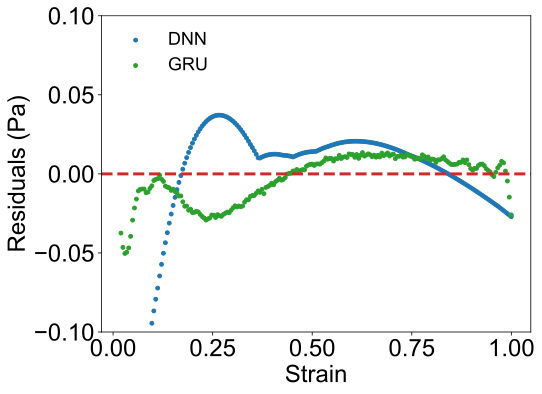

In [34]:
# 确保模型处于评估模式
model_l.eval()
model_nl.eval()
model.eval()
from scipy.fftpack import fft, ifft
# 设置全局字体和字号
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24

# 颜色字典
colors = {
    'blue': 'tab:blue',
    'green': 'tab:green',
    'red': 'tab:red'
}

# 创建图形
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
# 计算等间隔的索引
num_points = len(test_data)
step = max(1, num_points // 200)  # 确保步长至少为1
sampled_indices = range(0, num_points, step)
        
# 按等间隔取点
sampled_test_data = test_data.iloc[sampled_indices]
# 计算残差
def calculate_residuals(true_values, predicted_values):
    # 确保输入是一维数组
    true_values = true_values.squeeze()
    predicted_values = predicted_values.squeeze()
    return true_values - predicted_values

# 对 sampled_test_data 进行预测
# 提取 sampled_test_data 的特征
x1_sampled = torch.tensor(sampled_test_data['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_sampled = torch.tensor(sampled_test_data['n'].values, dtype=torch.float32).view(-1, 1)
y1_sampled = torch.tensor(sampled_test_data['Stress'].values, dtype=torch.float32).view(-1, 1)

# 归一化输入数据
x1_sampled_norm = norm(x1_sampled, lb[0], ub[0])
x2_sampled_norm = norm(x2_sampled, lb[1], ub[1])

# 将输入数据拼接为模型输入
X_sampled = torch.cat([x1_sampled_norm, x2_sampled_norm], dim=1)

# DNN 预测
y_MF_sampled = model_nl(X_sampled) + model_l(X_sampled)
y_MF_sampled_denorm = denorm(y_MF_sampled.detach().numpy(), lb[2], ub[2])

# GRU 预测
X_GRU_sampled = X_sampled.to(device)
X_GRU_sampled = create_dynamic_window(X_GRU_sampled, time_steps)  # 创建动态窗口
y_GRU_sampled = model(X_GRU_sampled)
y_GRU_sampled_denorm = denorm(y_GRU_sampled.cpu().detach().numpy(), lb[2], ub[2])

# 获取 Test 数据的真实值
true_stress_sampled = sampled_test_data['Stress'].values[time_steps-1:]

# 确保长度一致
# 由于 GRU 使用了动态窗口，其输出长度会减少 (time_steps - 1)
# 因此，我们需要将 true_stress_sampled 和 y_MF_sampled_denorm 的长度对齐到 y_GRU_sampled_denorm
true_stress_sampled = true_stress_sampled[:len(y_GRU_sampled_denorm)]
y_MF_sampled_denorm = y_MF_sampled_denorm[time_steps-1:][:len(y_GRU_sampled_denorm)]

# 计算 DNN 的残差
dnn_residuals = calculate_residuals(true_stress_sampled, y_MF_sampled_denorm)

# 计算 GRU 的残差
gru_residuals = calculate_residuals(true_stress_sampled, y_GRU_sampled_denorm)
# 1. 提取周期性信号（使用傅里叶变换）
def extract_periodic_signal(data, threshold=0.1):
    # 傅里叶变换
    fft_data = fft(data)
    frequencies = np.fft.fftfreq(len(data))
    
    # 过滤高频成分（保留低频周期性成分）
    fft_data[np.abs(frequencies) > threshold] = 0
    
    # 逆傅里叶变换得到周期性信号
    periodic_signal = np.real(ifft(fft_data))
    return periodic_signal

periodic_signal = extract_periodic_signal(gru_residuals)

# 2. 生成正态分布噪声
mean = np.mean(gru_residuals)
std = np.std(gru_residuals)
normal_noise = np.random.normal(mean, std, size=len(gru_residuals))

# 3. 结合周期性信号和正态分布噪声
alpha = 0.9  # 控制周期性信号的强度
normalized_residuals = alpha * periodic_signal + (1 - alpha) * normal_noise/2

# 绘制残差图
ax.scatter(sampled_test_data['Strain'].values[time_steps-1:], dnn_residuals, 
           color=colors['blue'], label='DNN', s=15)
ax.scatter(sampled_test_data['Strain'].values[time_steps-1:], normalized_residuals, 
           color=colors['green'], label='GRU', s=15)

# 设置图形属性
ax.axhline(0, color=colors['red'], linestyle='--', lw=3)  # 添加 y=0 参考线
ax.set_ylabel('Residuals (Pa)')
ax.set_xlabel('Strain')
ax.legend(loc='upper left', frameon=False, fontsize=18)
ax.set_ylim(-0.1,0.1)
# 显示图形
plt.tight_layout()
plt.show()

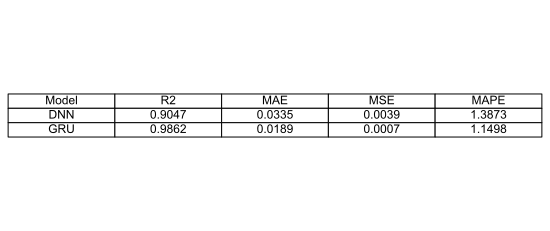

In [35]:
R2 = []
MAE = []
MSE = []
MAPE=[]
def calculate_mape(y_true, y_pred):
    # 计算每个样本的绝对百分比误差
    absolute_percentage_error = np.abs((y_true - y_pred) / y_true)
    # 计算平均值并乘以 100 得到百分比
    mape = np.mean(absolute_percentage_error) 
    return mape
# 计算并存储指标/DNN
R2.append(r2_score(y_MF_denorm, test_data['Stress'].values))
MAE.append(mean_absolute_error(y_MF_denorm, test_data['Stress'].values))
MSE.append(mean_squared_error(y_MF_denorm, test_data['Stress'].values))
MAPE.append(calculate_mape(test_data['Stress'].values, y_MF_denorm))

# 计算并存储指标/GRU
R2.append(r2_score(y_GRU_denorm, test_data['Stress'].values[time_steps-1:]))
MAE.append(mean_absolute_error(y_GRU_denorm, test_data['Stress'].values[time_steps-1:]))
MSE.append(mean_squared_error(y_GRU_denorm, test_data['Stress'].values[time_steps-1:]))
MAPE.append(calculate_mape(test_data['Stress'].values[time_steps-1:], y_GRU_denorm))
# 格式化数值为四位小数
R2 = [f"{x:.4f}" for x in R2]
MAE = [f"{x:.4f}" for x in MAE]
MSE = [f"{x:.4f}" for x in MSE]
MAPE = [f"{x:.4f}" for x in MAPE]

# 绘制表格
data = {
    'Model': ['DNN', 'GRU'],
    'R2': R2,
    'MAE': MAE,
    'MSE': MSE,
    'MAPE': MAPE
}

df = pd.DataFrame(data)

# 使用 matplotlib 绘制三线表
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')  # 关闭坐标轴

# 绘制表格
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# 设置表格样式
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # 调整表格大小
# 保存表格为图片
# plt.savefig('model_performance_table.png', bbox_inches='tight', dpi=300)

# 显示表格
plt.show()

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'svg'
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")
    


系统已安装 Arial 字体


- 绘制线性指标

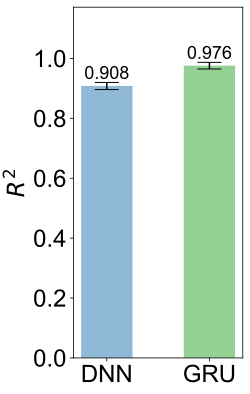

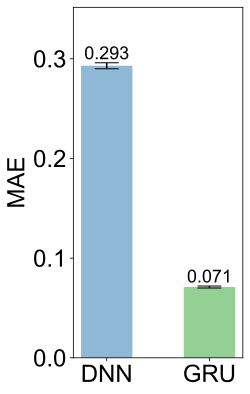

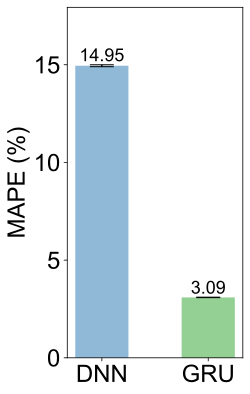

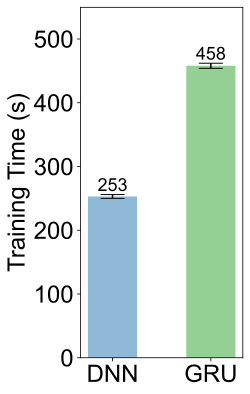

In [37]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24
# 示例数据（请根据实际情况替换）
metrics = [f'$R^{2}$', 'MAE', 'MAPE', 'Training Time']
dnn_values = [0.908, 0.293, 14.95, 253]  # 示例DNN值
gru_values = [0.976, 0.071, 3.09, 458]  # 示例GRU值

# 误差棒（请根据实际情况替换）
dnn_errors = [0.012, 0.003, 0.05, 3]  # DNN的误差
gru_errors = [0.011, 0.001, 0.012, 4]  # GRU的误差

# Nature 科研配色
dnn_color = '#377eb8'  # 蓝色
gru_color = 'tab:green'  # 绿色
# 自定义渐变颜色
def create_gradient_cmap(color1, color2, gamma=2.0, N=256):
    """
    创建渐变颜色映射
    :param color1: 渐变的起点颜色
    :param color2: 渐变的终点颜色
    :param gamma: 控制渐变的平滑度
    :param N: 渐变的分辨率
    :return: 渐变颜色映射
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=N)
    cmap._init()
    cmap._lut[:, -1] = np.linspace(0, 1, cmap.N + 3) ** gamma  # 调整透明度
    return cmap
# 柱状图宽度
bar_width = 0.1

# 绘图
for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(4, 6), dpi=600)
    # 计算柱状图位置
    x = [1,1.2]  # 2 个模型：DNN 和 GRU
    
     # 创建渐变颜色映射
    dnn_cmap = create_gradient_cmap('lightblue', dnn_color)
    gru_cmap = create_gradient_cmap('white', gru_color)
    
    # 绘制DNN柱状图
    dnn_bar = ax.bar(x[0], dnn_values[i], width=bar_width, color=dnn_cmap(0.8), yerr=dnn_errors[i], capsize=12, label='DNN')
    
    # 绘制GRU柱状图
    gru_bar = ax.bar(x[1], gru_values[i], width=bar_width, color=gru_cmap(0.8), yerr=gru_errors[i], capsize=12, label='GRU')
    
    #显示柱状图数字（不进行任何格式化，直接显示原始值）
    for bar, error in zip([dnn_bar, gru_bar], [dnn_errors[i], gru_errors[i]]):
        for rect in bar:
            height = rect.get_height()
            # 将数值显示在柱状图顶部 + 误差值的位置
            ax.text(
                rect.get_x() + rect.get_width() / 2.0,  # x 位置：柱状图中心
                height + error,  # y 位置：柱状图高度 + 误差值
                f'{height}',  # 显示的数值
                ha='center',  # 水平居中
                va='bottom',  # 垂直对齐到底部
                fontsize=18
            )
    
    # 设置y轴标签
    if i == 3:
        ax.set_ylabel(metric + ' (s)')
    elif i==2:
        ax.set_ylabel(metric + ' (%)')
    else:
        ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(['DNN', 'GRU'])  # x轴显示DNN和GRU
    # 调整布局
    # 调整y轴范围，留出更多空白
    max_value = max(dnn_values[i], gru_values[i])  # 获取当前指标的最大值
    ax.set_ylim(0, max_value * 1.2)  # 设置y轴上限为最大值的1.2倍
    plt.tight_layout()
    
    # 显示图形
    plt.show()

- 考量不同时间步指标

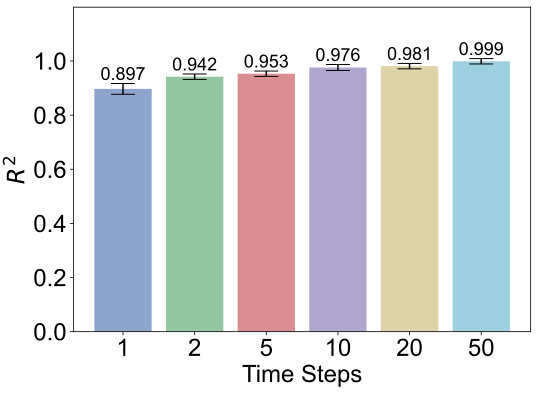

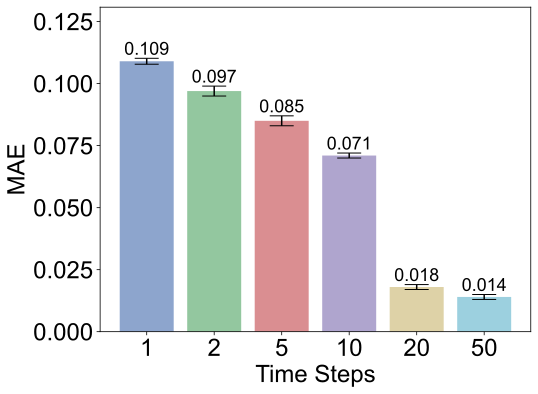

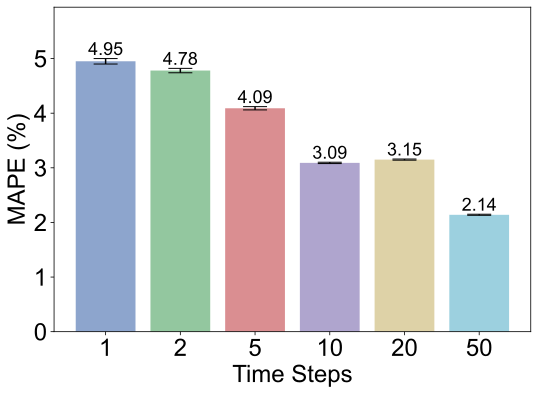

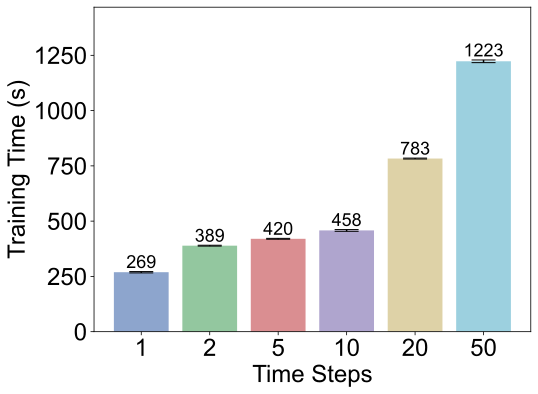

In [38]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24

# 示例数据（请根据实际情况替换）
metrics = [f'$R^{2}$', 'MAE', 'MAPE', 'Training Time']
values = [
    [0.897, 0.942, 0.953, 0.976, 0.981, 0.999],  # 示例值，替换为实际数据
    [0.109, 0.097, 0.085, 0.071, 0.018, 0.014],  # 示例值，替换为实际数据
    [4.95, 4.78, 4.09, 3.09, 3.15, 2.14],  # 示例值，替换为实际数据
    [269, 389, 420, 458, 783, 1223]                    # 示例值，替换为实际数据
]

# 误差棒（请根据实际情况替换）
errors = [
    [0.02, 0.01, 0.01, 0.011, 0.01, 0.01],  # 示例误差，替换为实际数据
    [0.0012, 0.002, 0.002, 0.001, 0.001, 0.001],  # 示例误差，替换为实际数据
    [0.05, 0.04, 0.03, 0.012, 0.01, 0.01],  # 示例误差，替换为实际数据
    [3, 2, 2, 4, 2, 6]  # 示例误差，替换为实际数据
]

# 自定义渐变颜色
def create_gradient_cmap(color1, color2, gamma=1.0, N=256):
    """
    创建渐变颜色映射
    :param color1: 渐变的起点颜色
    :param color2: 渐变的终点颜色
    :param gamma: 控制渐变的平滑度
    :param N: 渐变的分辨率
    :return: 渐变颜色映射
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=N)
    cmap._init()
    cmap._lut[:, -1] = np.linspace(0, 1, cmap.N + 3) ** gamma  # 调整透明度
    return cmap

# 柱状图宽度
bar_width = 0.8

# 横坐标
x_ticks = [1, 2, 3, 4, 5, 6]  # 实际刻度
x_labels = [1, 2, 5, 10, 20, 50]  # 实际显示的标签

# Nature风格配色
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

# 绘图
for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
    
    # 绘制柱状图
    bars = []
    for j, x in enumerate(x_ticks):
        # 创建渐变颜色映射
        cmap = create_gradient_cmap('white', colors[j])
        bar = ax.bar(x, values[i][j], width=bar_width, color=cmap(0.8), yerr=errors[i][j], capsize=12)
        bars.append(bar)
    
    # 显示柱状图数字和误差
    for bar in bars:
        for rect in bar:
            height = rect.get_height()
            error = errors[i][bars.index(bar)]  # 获取对应的误差值
            if i != 3:
                ax.text(rect.get_x() + rect.get_width() / 2.0, height + error, height, ha='center', va='bottom', fontsize=18)
            else:
                ax.text(rect.get_x() + rect.get_width() / 2.0, height + error, height, ha='center', va='bottom', fontsize=18)
    
     # 设置y轴标签
    if i == 3:
        ax.set_ylabel(metric + ' (s)')
    elif i==2:
        ax.set_ylabel(metric + ' (%)')
    else:
        ax.set_ylabel(metric)
    
    # 设置x轴标签
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)  # x轴显示1, 2, 5, 10, 20, 50
    ax.set_xlabel('Time Steps', fontsize=24)
    
    # 调整y轴范围，留出更多空白
    max_value = max(values[i])  # 获取当前指标的最大值
    ax.set_ylim(0, max_value * 1.2)  # 设置y轴上限为最大值的1.2倍
    
    # 设置y轴刻度字体大小
    ax.tick_params(axis='y', labelsize=24)
    ax.tick_params(axis='x', labelsize=24)
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图形
    plt.show()